<a href="https://colab.research.google.com/github/vijay-93/Twitter_tweet_-Sentiment-analysis/blob/main/Tweet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Sentiment Analysis of Twitter -Tweets
### Importing Library
### Reading the Dataset

In [48]:
#Importing the necessary librarires

import math
import nltk
import scipy
import string
import re
import numpy as np
import pandas as pd
import seaborn as sns

from tqdm import tqdm
from scipy.stats import randint
from wordcloud import WordCloud
from multiprocessing import Pool
from nltk.corpus import stopwords
from scipy.stats import loguniform

from sklearn.decomposition import PCA
from nltk.stem.porter import PorterStemmer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,RandomizedSearchCV,RepeatedStratifiedKFold,GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
import lightgbm as lgb
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score,roc_auc_score, roc_curve, precision_score, recall_score
from IPython.display import display
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20,6]
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('punkt')
import warnings 
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [49]:
#Importing the dataset

tweets_df = pd.read_csv('Tweets.csv', header=0)

In [50]:
tweets_df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [51]:
tweets_df.describe(include='O')

,textID,text,selected_text,sentiment
count,27481,27480,27480,27481
unique,27481,27480,22463,3
top,cb774db0d1,"I`d have responded, if I were going",good,neutral
freq,1,1,199,11118


In [52]:
tweets_df.drop(['selected_text', 'textID'], axis=1, inplace=True)

In [53]:
tweets_df.head()

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative


In [54]:
target = 'sentiment'

In [55]:
original_df = tweets_df.copy(deep=True)

In [56]:
print('\n\033[1mData Dimension:\033[0m Dataset consists of {} columns & {} records.'.format(tweets_df.shape[1], tweets_df.shape[0]))


Data Dimension: Dataset consists of 2 columns & 27481 records.


In [57]:
#Checking the dtypes of all the columns

tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       27480 non-null  object
 1   sentiment  27481 non-null  object
dtypes: object(2)
memory usage: 429.5+ KB


In [58]:
#Checking the stats of all the columns

tweets_df.describe()

,text,sentiment
count,27480,27481
unique,27480,3
top,"I`d have responded, if I were going",neutral
freq,1,11118


In [59]:
#Check for empty elements

tweets_df.isnull().sum()

text         1
sentiment    0
dtype: int64

In [60]:
#Dropping the null values
tweets_df.dropna(inplace=True)
original_df = tweets_df.copy()

In [61]:
tweets_df[tweets_df.duplicated()]

,text,sentiment


In [62]:
#Removal of any Duplicate rows (if any)

counter = 0
r,c = original_df.shape

tweets_df_dedup = tweets_df.drop_duplicates()
tweets_df_dedup.reset_index(drop=True, inplace=True)

if tweets_df_dedup.shape==(r,c):
    print('\n\033[1mInference:\033[0m The dataset doesn\'t have any duplicates')
else:
    print(f'\n\033[1mInference:\033[0m Number of duplicates dropped/fixed ---> {r-tweets_df_dedup.shape[0]}')


Inference: The dataset doesn't have any duplicates


In [63]:
tweets_df_dedup.head()

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative


### Basic Text processing Methods:

1)Convert to lowercase
2)Tokenisation
3)Remove puntuation
4)Remove Stop words
5)Lemmatisation

In [65]:
#Filtering the text

tweets_df_fltr = tweets_df_dedup.copy()

def preprocessor(text):
    #text = re.sub('[http:,https:]','',text)
    text = re.sub('[^a-zA-Z]',' ',text)
    text = text.lower()
    text = text.strip()
    text = ''.join([i for i in text if i in string.ascii_lowercase+' '])
    text = ' '.join([word for word in text.split() if word.isalnum()])
    text = ' '.join([WordNetLemmatizer().lemmatize(word,pos='v') for word in text.split()])    
    #text = ' '.join([PorterStemmer().stem(word) for word in text.split()])
    text = ' '.join([word for word in text.split() if word not in stopwords.words('english')])
    #text = ' '.join([word for word in text.split() if len(word)>3])
    return text


In [72]:
text

<module 'sklearn.feature_extraction.text' from '/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py'>

In [73]:
porter=PorterStemmer()

def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

In [74]:
tfidf=TfidfVectorizer(strip_accents=None,lowercase=False,preprocessor=None,tokenizer=tokenizer_porter,use_idf=True,norm='l2',smooth_idf=True)
label=tweets_df_fltr[target].values
features=tfidf.fit_transform(tweets_df_fltr.text)

In [75]:
label

array(['neutral', 'negative', 'negative', ..., 'positive', 'positive',
       'neutral'], dtype=object)

In [76]:
features

<27480x41640 sparse matrix of type '<class 'numpy.float64'>'
	with 336973 stored elements in Compressed Sparse Row format>

### Exploratory Data Analysis (EDA)


            Target Variable Distribution           


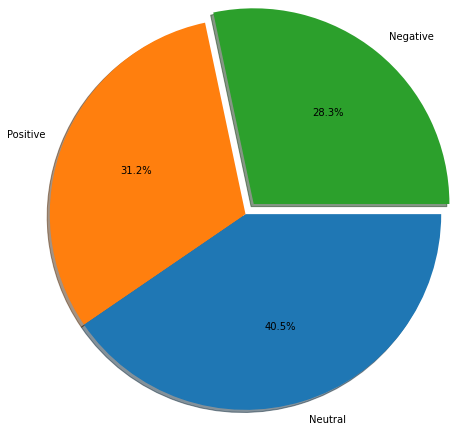

In [77]:
#Let us first analyze the distribution of the target variable

print('\033[1mTarget Variable Distribution'.center(55))
plt.pie(tweets_df_fltr[target].value_counts(), labels=['Neutral','Positive','Negative'], counterclock=False, shadow=True, 
        explode=[0,0,0.1], autopct='%1.1f%%', radius=1.5, startangle=0)
plt.show()

Inference: The Target Variable seems to be slightly imbalanced!



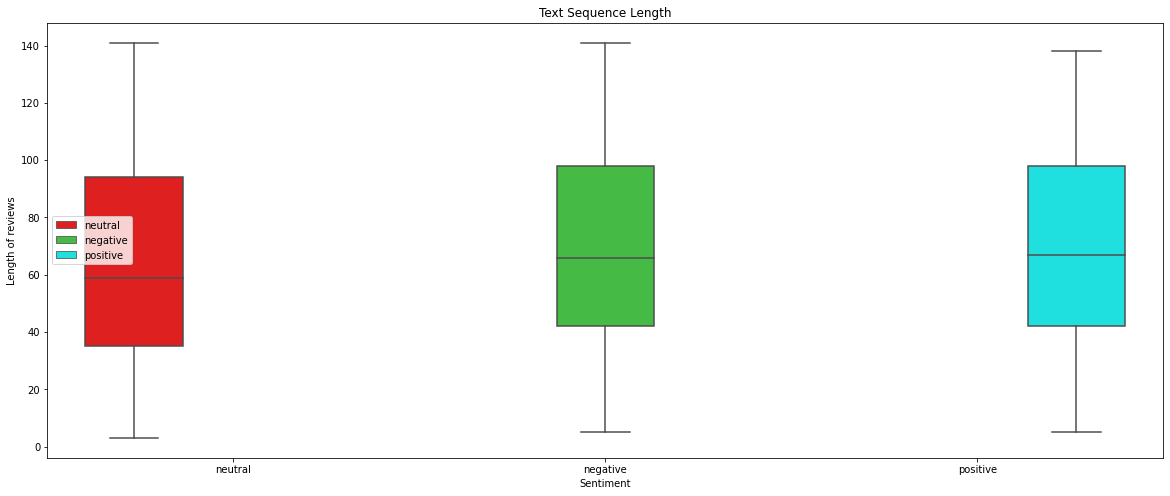

In [78]:
# Visualising the average text sequence length

tweets_df_rl = tweets_df_fltr.copy()
tweets_df_rl['review_length'] = 0


tweets_df_rl['review_length'] = tweets_df_rl['text'].apply(lambda x: len(x))

plt.figure(figsize=[20,8])
sns.boxplot(x=label,y='review_length', data=tweets_df_rl, hue=label,palette=['red','limegreen','cyan'])
plt.title('Text Sequence Length')
plt.xlabel("Sentiment")
plt.ylabel("Length of reviews")
plt.show()

The sequence length for reviews on an average are almost similiar through positive, negative & neutral tweets.

In [79]:
neut_df = original_df[original_df[target]=='neutral']['text']
pos_df = original_df[original_df[target]=='positive']['text']

neg_df = original_df[original_df[target]== 'negative']['text']

In [80]:
def freq_text(text_df):

    combi_text=""
    for x in text_df.values:
        combi_text+=' '.join(x.split())
    combi_text  = [x for x in combi_text.split() if len(x) >3 and x not in stopwords.words('english')]  
    return combi_text

In [81]:
def freq_df(text_count_df,senti):
    fredis = nltk.FreqDist(neut_text)
    fredis_df = pd.DataFrame({senti: list(fredis.keys()),
                      'Count': list(fredis.values())})
    fredis_df = fredis_df.sort_values(by='Count',ascending=False)
    return fredis_df

In [82]:
def plot_freq_dis(text_count_df,senti):
    sns.barplot(data=text_count_df[:10],x=senti,y='Count')

In [83]:
neut_df.shape

(11117,)

In [85]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [86]:
neut_df = neut_df.apply(preprocessor)

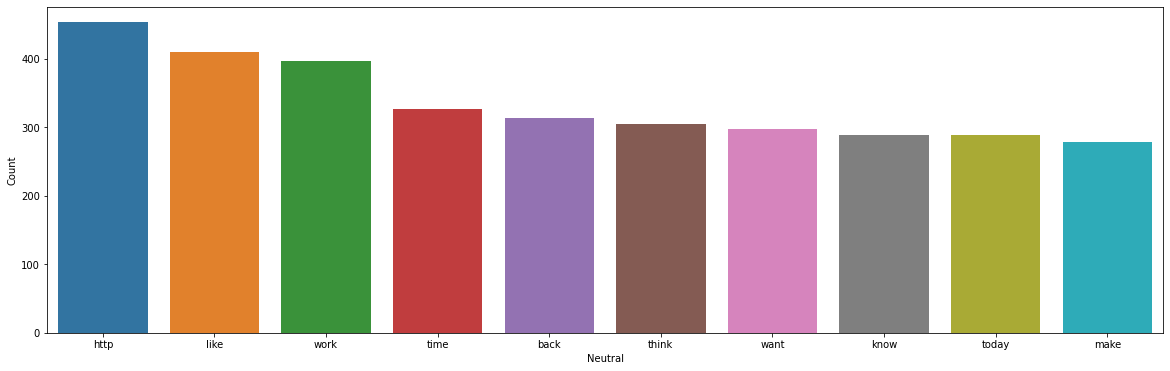

In [87]:
senti ='Neutral'
neut_text = freq_text(neut_df)
neut_frq_df = freq_df(neut_text,senti)
plot_freq_dis(neut_frq_df,senti)

In [88]:
pos_df.shape

(8582,)

In [89]:
pos_df = pos_df.apply(preprocessor)

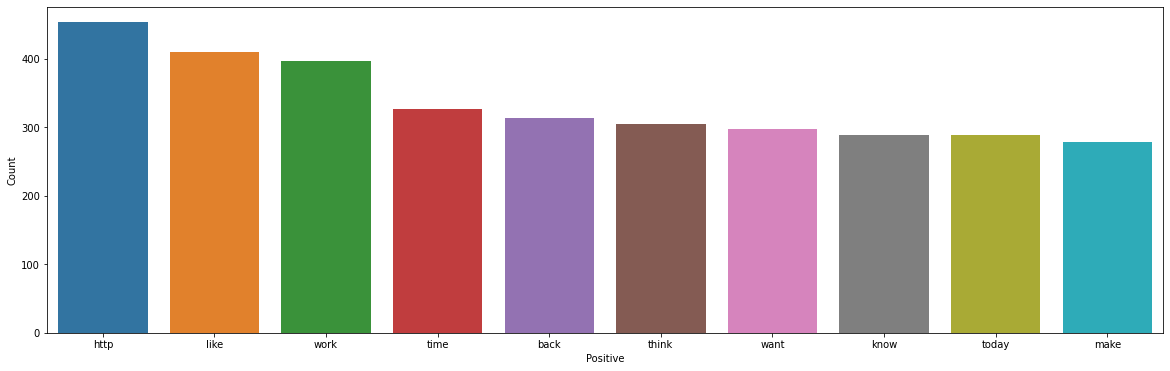

In [90]:
senti ='Positive'
pos_df_text = freq_text(pos_df)
pos_frq_df = freq_df(pos_df_text,senti)
plot_freq_dis(pos_frq_df,senti)

In [91]:
neg_df.shape

(7781,)

In [92]:
neg_df = neg_df.apply(preprocessor)

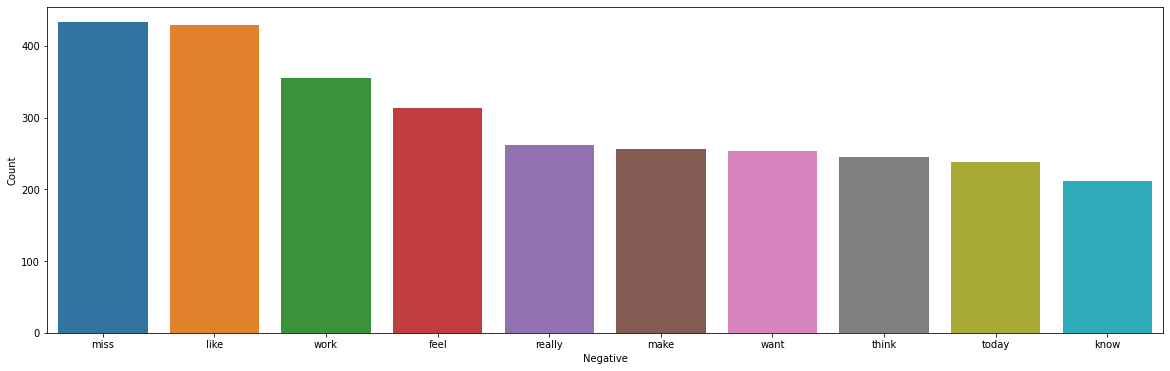

In [93]:
senti ='Negative'
neut_text = freq_text(neg_df)
neut_frq_df = freq_df(neut_text,senti)
plot_freq_dis(neut_frq_df,senti)

In [94]:
def wordcloud_draw(data, color, s):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split() if(word!='movie' and word!='film')])
    wordcloud = WordCloud(stopwords=stopwords.words('english'),background_color=color,width=2500,height=2000).generate(cleaned_word)
    plt.imshow(wordcloud)
    plt.title(s)
    plt.axis('off')

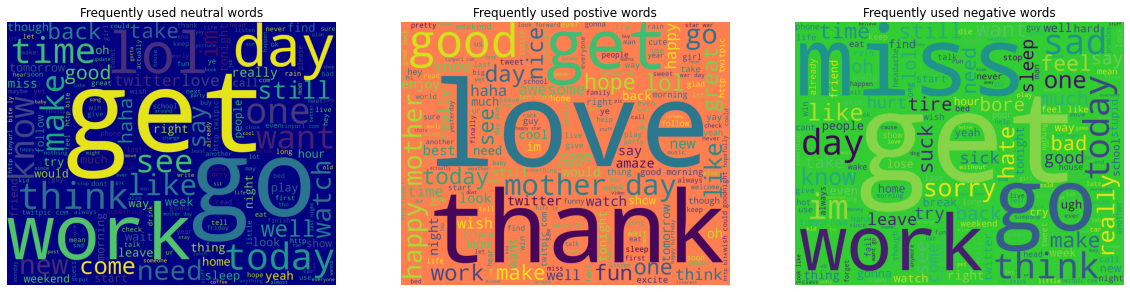

In [95]:
plt.figure(figsize=[20,10])
plt.subplot(1,3,1)
wordcloud_draw(neut_df,'navy','Frequently used neutral words')
plt.subplot(1,3,2)
wordcloud_draw(pos_df,'coral','Frequently used postive words')
plt.subplot(1,3,3)
wordcloud_draw(neg_df, 'limegreen','Frequently used negative words')
plt.show()

## Predictive Modeling

In [96]:
# Assigning labels to target variable

label_mapping={'negative':0, 'neutral':1, 'positive':2}
tweets_df_fltr['sentiment'] = tweets_df_fltr['sentiment'].map(label_mapping)

In [97]:
#Splitting the data intro training & testing sets

X = features
y = pd.Series(label).map(label_mapping)

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=0)

print('Original set  ---> ','feature size: ',X.shape,'label size',len(y))
print('Training set  ---> ','feature size: ',X_train.shape,'label size',len(y_train))
print('Testing set   ---> ','feature size: ',X_test.shape,'label size',len(y_test))

Original set  --->  feature size:  (27480, 41640) label size 27480
Training set  --->  feature size:  (21984, 41640) label size 21984
Testing set   --->  feature size:  (5496, 41640) label size 5496


In [99]:
#Let us create first create a table to store the results of various models 

result_df = pd.DataFrame(columns=['Models','Accuracy', 'Precision','Recall','F1-score','AUC-ROC score'])
result_df['Models']=['Logistic Regression (LR)','Decision Tree Classifier (DT)','Random Forest Classifier (RF)','Naïve Bayes Classifier (NB)']
result_df.fillna(0.0,inplace=True)
result_df.set_index('Models',inplace=True)
result_df

,Accuracy,Precision,Recall,F1-score,AUC-ROC score
Models,,,,,
Logistic Regression (LR),0.0,0.0,0.0,0.0,0.0
Decision Tree Classifier (DT),0.0,0.0,0.0,0.0,0.0
Random Forest Classifier (RF),0.0,0.0,0.0,0.0,0.0
Naïve Bayes Classifier (NB),0.0,0.0,0.0,0.0,0.0


In [100]:
result_df.loc['Logistic Regression (LR)','Accuracy']

0.0

In [101]:
#Classification Summary Function
def classification_summary(pred,pred_prob,model):
    result_df.loc[model,'Accuracy']   =round(accuracy_score(y_test,pred),3)*100   
    result_df.loc[model,'Precision']=round(precision_score(y_test, pred, average='weighted'),3)*100 #, average='weighted'
    result_df.loc[model,'Recall']=round(recall_score(y_test, pred, average='weighted'),3)*100 #, average='weighted'
    result_df.loc[model,'F1-score']=round(f1_score(y_test, pred, average='weighted'),3)*100 #, average='weighted'
    result_df.loc[model,'AUC-ROC score']=round(roc_auc_score(y_test, pred_prob, multi_class='ovr'),3)*100 #, multi_class='ovr'
    
    print('{}{}\033[1m Evaluating {} \033[0m{}{}\n'.format('<'*3,'-'*35,model, '-'*35,'>'*3))
    print('Accuracy = {}%'.format(round(accuracy_score(y_test, pred),3)*100))
    print('F1 Score = {}%'.format(round(f1_score(y_test, pred, average='weighted'),3)*100)) #, average='weighted'
    print('Precision Score = {}%'.format(round(precision_score(y_test, pred, average='weighted'),3)*100))
    print('Recall Score = {}%'.format(round(recall_score(y_test, pred, average='weighted'),3)*100))
    print('\n \033[1mConfusiton Matrix:\033[0m\n',confusion_matrix(y_test, pred))
    print('\n\033[1mClassification Report:\033[0m\n',classification_report(y_test, pred))
    
    auc_roc(y_test, pred_prob, curves=['each_class'])
    plt.show()

In [102]:
#Visualising Function
def auc_roc_plot(y_test, pred):    
    ref = [0 for _ in range(len(y_test))]
    ref_auc = roc_auc_score(y_test, ref)
    lr_auc = roc_auc_score(y_test, pred)

    ns_fpr, ns_tpr, _ = roc_curve(y_test, ref)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, pred)

    plt.plot(ns_fpr, ns_tpr, linestyle='=')
    plt.plot(lr_fpr, lr_tpr, marker='*', label='AUC = {}'.format(round(roc_auc_score(y_test, pred)*100,2))) 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

## Logistic Regression


In [114]:
# Building Logistic Regression Classifier

log_reg_model = LogisticRegression()
log_reg_model.fit(X_train, y_train)
pred = log_reg_model.predict(X_test)
pred_prob = log_reg_model.predict_proba(X_test)
classification_summary(pred,pred_prob,'Logistic Regression (LR)')


<<<----------------------------------- Evaluating Logistic Regression (LR) ----------------------------------->>>

Accuracy = 66.7%
F1 Score = 66.60000000000001%
Precision Score = 68.0%
Recall Score = 66.7%

 Confusiton Matrix:
 [[ 828  613   82]
 [ 276 1740  259]
 [  87  512 1099]]

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.54      0.61      1523
           1       0.61      0.76      0.68      2275
           2       0.76      0.65      0.70      1698

    accuracy                           0.67      5496
   macro avg       0.69      0.65      0.66      5496
weighted avg       0.68      0.67      0.67      5496



NameError: ignored

Decision Tree Classifier

In [115]:
# Building Decision Tree Classifier

DT_model = DecisionTreeClassifier()
DT_model.fit(X_train, y_train)
pred = DT_model.predict(X_test)
pred_prob = DT_model.predict_proba(X_test)
classification_summary(pred,pred_prob,'Decision Tree Classifier (DT)')

<<<----------------------------------- Evaluating Decision Tree Classifier (DT) ----------------------------------->>>

Accuracy = 57.599999999999994%
F1 Score = 57.599999999999994%
Precision Score = 57.599999999999994%
Recall Score = 57.599999999999994%

 Confusiton Matrix:
 [[ 781  539  203]
 [ 468 1368  439]
 [ 202  480 1016]]

Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.51      0.53      1523
           1       0.57      0.60      0.59      2275
           2       0.61      0.60      0.61      1698

    accuracy                           0.58      5496
   macro avg       0.57      0.57      0.57      5496
weighted avg       0.58      0.58      0.58      5496



NameError: ignored

Random Forest Classifier:

In [116]:
# Building Random Forest Classifier

RF_model = RandomForestClassifier()
RF_model.fit(X_train, y_train)
pred = RF_model.predict(X_test)
pred_prob = RF_model.predict_proba(X_test)
classification_summary(pred,pred_prob,'Random Forest Classifier (RF)')

<<<----------------------------------- Evaluating Random Forest Classifier (RF) ----------------------------------->>>

Accuracy = 64.3%
F1 Score = 63.9%
Precision Score = 66.7%
Recall Score = 64.3%

 Confusiton Matrix:
 [[ 716  730   77]
 [ 226 1795  254]
 [  72  603 1023]]

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.47      0.56      1523
           1       0.57      0.79      0.66      2275
           2       0.76      0.60      0.67      1698

    accuracy                           0.64      5496
   macro avg       0.68      0.62      0.63      5496
weighted avg       0.67      0.64      0.64      5496



NameError: ignored

Naive Bayes Classfier

In [117]:
# Building Naive Bayes Classifier

NB_model = BernoulliNB()
NB_model.fit(X_train,y_train)
pred = NB_model.predict(X_test)
pred_prob = NB_model.predict_proba(X_test)
classification_summary(pred,pred_prob,'Naïve Bayes Classifier (NB)')

<<<----------------------------------- Evaluating Naïve Bayes Classifier (NB) ----------------------------------->>>

Accuracy = 59.699999999999996%
F1 Score = 58.199999999999996%
Precision Score = 63.7%
Recall Score = 59.699999999999996%

 Confusiton Matrix:
 [[ 510  937   76]
 [ 184 1867  224]
 [  64  730  904]]

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.33      0.45      1523
           1       0.53      0.82      0.64      2275
           2       0.75      0.53      0.62      1698

    accuracy                           0.60      5496
   macro avg       0.65      0.56      0.57      5496
weighted avg       0.64      0.60      0.58      5496



NameError: ignored

In [118]:
#Plotting Confusion-Matrix of all the predictive Models

labels=['Positive','Negative']
def plot_cm(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.columns=labels
    cm.index=labels
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    #fig, ax = plt.subplots()
    sns.heatmap(cm, annot=annot, fmt='')# cmap= "GnBu"


In [119]:
def conf_mat_plot(all_models):
    plt.figure(figsize=[20,3*math.ceil(1+len([all_models])/4)])
    
    for i in range(len(all_models)):
        if len(labels)<=4:
            plt.subplot(1,4,i+1)
        else:
            plt.subplot(math.ceil(len(all_models)/2),2,i+1)
        pred = all_models[i].predict(X_test)
        #plot_cm(Test_Y, pred)
        sns.heatmap(confusion_matrix(y_test, pred), annot=True, fmt='.0f') #vmin=0,vmax=5,cmap='BuGn'
        plt.title(result_df.index[i])
        plt.yticks([0,1,2],labels=['Predicted Negative','Predicted Netural','Predicted Positive'],rotation=45)
        plt.xticks([0,1,2],labels=['Actual Negative','Actual Netural','Actual Positive'],rotation=45)
    plt.tight_layout()
    plt.show()

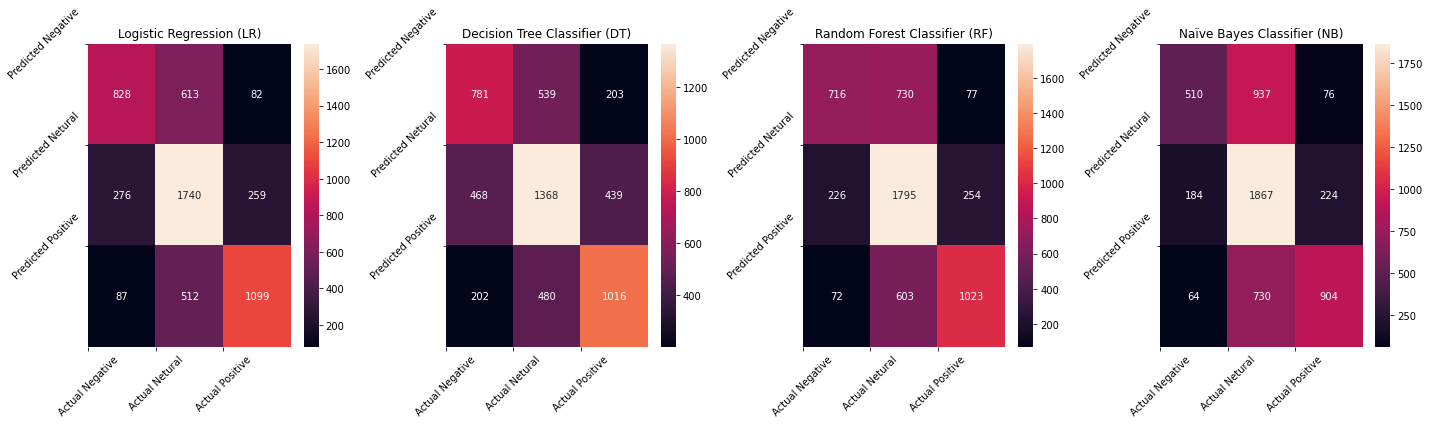

In [120]:
conf_mat_plot([log_reg_model,DT_model,RF_model,NB_model])

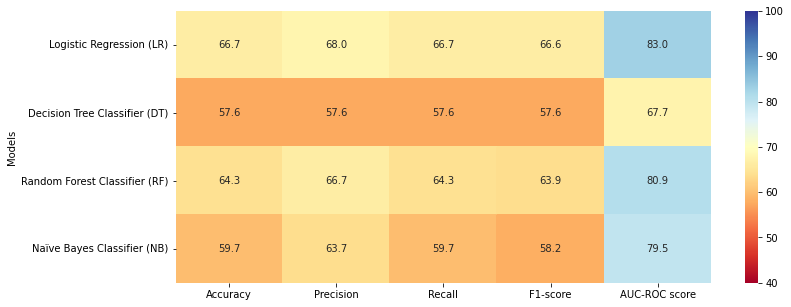

In [121]:
#Comparing all the models Scores

plt.figure(figsize=[12,5])
sns.heatmap(result_df, annot=True, vmin=40, vmax=100.0, cmap='RdYlBu', fmt='.1f')
plt.show()

Focusing on the F1-score random forest classifier performs the best on the current dataset. Performance can be increased using hyperparameter tuning. Lets try with some random values for some of the paramters

In [122]:
param_grid = { 
    'n_estimators': [100,200,300,500],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [1,2,4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [ ]:
CV_rfc = GridSearchCV(estimator=RF_model, param_grid=param_grid, cv= 5,n_jobs=-1)
CV_rfc.fit(X_train, y_train)

In [ ]:
CV_rfc.best_params_

In [ ]:
RF_model_cv=RandomForestClassifier(random_state=42,**CV_rfc.best_params_)

In [ ]:
RF_model_cv.fit(X_train, y_train)

In [ ]:
conf_mat_plot([RF_model_cv])

In [ ]:
pred = RF_model_cv.predict(X_test)
pred_prob = RF_model_cv.predict_proba(X_test)
print(classification_report(y_test,pred))
accuracy_score(y_test,pred)
print(round(roc_auc_score(y_test, pred_prob, multi_class='ovr'),3)*100)
auc_roc(y_test,pred_prob)